In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.data as skdata
from project.algorithms.simulation import dummy_object, ptychogram, mesh, illumination_beam
from project.algorithms.utils import circ_aperture, normalize, nrmse, ft, ift, corr
from project.algorithms.reconstruction import update_obj, update_probe, TransRefinement, epie
import random

In [2]:
# Turn off for white background/jupyter notebook
background_dark = True
if background_dark:
    plt.style.use('dark_background')

In [3]:
"ground truth"
intensity = np.array(plt.imread('lena.tif'))
phase = skdata.camera()
obj = dummy_object(intensity=intensity, phase=phase, output_shape=(256, 256))
box_shape = (161, 161)   # the size of reconstruction box
r = 0.5
illumination = illumination_beam(box_shape, beam_radius=r)
illumination = normalize(illumination)

In [11]:
"positions and ptychogram"
positions = mesh((256, 256), 40, 0.75, 7, error=7)
# positions = np.load('positions.npy')
patterns = []
for position in positions:
    pattern = ptychogram(obj, illumination, position)
    patterns.append(pattern)

In [12]:
"initial guess positions"
guess_positions = np.array(positions)
error = 10
perror = np.random.randint(-error, error+1, size=guess_positions.shape)
guess_positions += perror
ini_guess = guess_positions.copy()

In [119]:
"initial estimation and parameter"
guess_probe = circ_aperture(box_shape, radius=0.4).astype('complex')
guess_obj = np.ones(obj.shape, dtype="complex")
guess_positions = positions.copy()
beta = [0] * 2
a, b = 1., 1.

In [120]:
"outputs"
loss, mpe = [], []
bx, by = [], []

In [121]:
"reconstruction"
(K, L) = guess_probe.shape
obj_pad = np.pad(guess_obj, ((K // 2, K // 2), (L // 2, L // 2)))
position_errors = np.zeros((len(positions), 2, 2))

for n in range(300):
    loss_vals = []
    index = random.sample(range(0, len(positions)), len(positions))
    position_errors[:, :, 0] = position_errors[:, :, 1].copy()
    for i in index:
        x = guess_positions[i][1]
        y = guess_positions[i][0]
        pattern = patterns[i]
        obj_scanned = obj_pad[y:y + K, x:x + L]

        "revise the wave function in diffraction plane"
        psi = obj_scanned * guess_probe
        Psi = ft(psi)
        phase_Psi = np.exp(1j * np.angle(Psi))
        Psi_corrected = np.sqrt(pattern) * phase_Psi
        psi_corrected = ift(Psi_corrected)

        "update the object and probe functions"
        diff_psi = psi_corrected - psi
        temp_obj = obj_scanned.copy()
        obj_scanned = update_obj(obj_scanned, guess_probe, diff_psi, learning_rate=a)
        obj_pad[y:y + K, x:x + L] = obj_scanned
        guess_probe = update_probe(guess_probe, temp_obj, diff_psi, learning_rate=b)

        "NRMSE"
        loss_vals.append(nrmse(np.abs(Psi), pattern))

        "position correction"
        if n >= 3:
            mask = guess_probe > 0.1
            syj, sxj = TransRefinement(obj_scanned, temp_obj, integer_skip=False)
            dy, dx = round(syj * beta[0]), round(sxj * beta[1])
            y += dy
            x += dx

            if y < 0:
                y = 1
            elif y >= guess_obj.shape[0]:
                y = guess_obj.shape[0] - 1
            if x < 0:
                x = 1
            elif x >= guess_obj.shape[1]:
                x = guess_obj.shape[1] - 1
            guess_positions[i] = np.array([y, x])
            position_errors[i, :, 1] = np.array([syj, sxj])

    "update beta"
    if n >= 10000:
        ky = corr(position_errors[:, 0, 0], position_errors[:, 0, 1])
        kx = corr(position_errors[:, 1, 0], position_errors[:, 1, 1])

        if ky >= 0.4:
            beta[0] = int(beta[0] * 1.1)
        elif ky <= -0.4:
            beta[0] = int(beta[0] * 0.9)
        if kx >= 0.4:
            beta[1] = int(beta[1] * 1.1)
        elif kx <= -0.4:
            beta[1] = int(beta[1] * 0.9)
    bx.append(beta[1])
    by.append(beta[0])

    pe = guess_positions - np.array(positions)   # position errors
    pe = np.sum(np.sqrt(pe[:, 0]**2 + pe[:, 1]**2)) / 49
    mpe.append(pe)
    loss.append(np.mean(loss_vals))

    guess_obj = obj_pad[K // 2:-K // 2 + 1, L // 2:-L // 2 + 1]

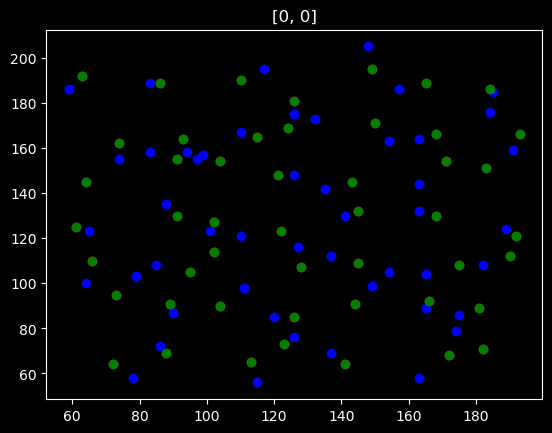

In [122]:
"plot position maps"
plt.figure()
plt.scatter(*np.transpose(positions), color='r')
plt.scatter(*np.transpose(ini_guess), color='b')
plt.scatter(*np.transpose(guess_positions), color='g')
plt.title(beta)
plt.show()

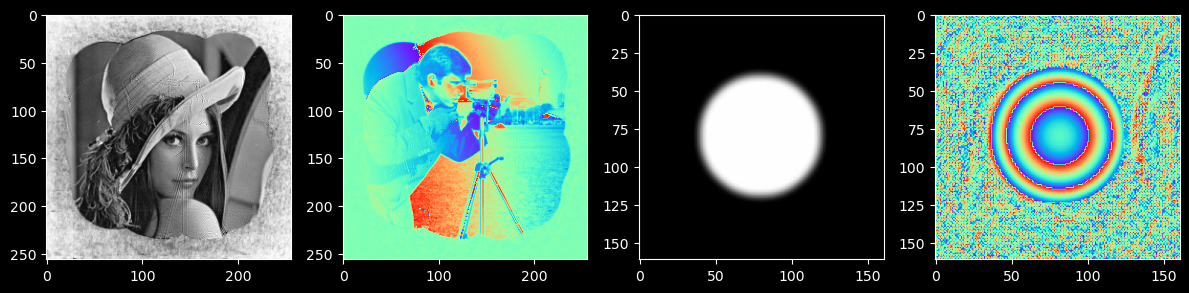

In [123]:
"imshow retrieved object and probe"
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(np.abs(guess_obj), cmap='gray')
axes[1].imshow(np.angle(guess_obj), cmap='rainbow')
axes[2].imshow(np.abs(guess_probe), cmap='gray')
axes[3].imshow(np.angle(guess_probe), cmap='rainbow')
plt.tight_layout()

In [124]:
"data save"
c = False
if c:
    np.save('./result_store/positions%ic.npy'%beta[0], guess_positions)
    np.save('./result_store/obj%ic.npy'%bx[0], guess_obj)
    np.save('./result_store/probe%ic.npy'%bx[0], guess_probe)
    np.save('./result_store/nrmse%ic.npy'%bx[0], loss)
    np.save('./result_store/mpe%ic.npy'%bx[0], mpe)
else:
    np.save('./result_store/positions%i.npy'%beta[0], guess_positions)
    np.save('./result_store/obj%i.npy'%bx[0], guess_obj)
    np.save('./result_store/probe%i.npy'%bx[0], guess_probe)
    np.save('./result_store/nrmse%i.npy'%bx[0], loss)
    np.save('./result_store/mpe%i.npy'%bx[0], mpe)

In [125]:
mpe[-1]

0.0

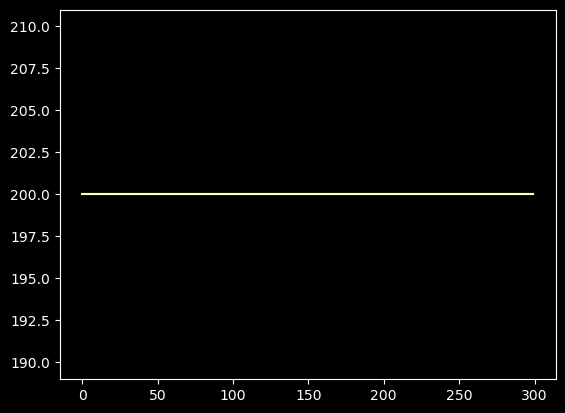

In [87]:
plt.plot(bx)
plt.plot(by)